In [2]:
import tensorflow as tf
import os
import glob
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [29]:
imgs_path = glob.glob('../input/cityscapes-image-pairs/cityscapes_data/train/*.jpg')
len(imgs_path)

2975

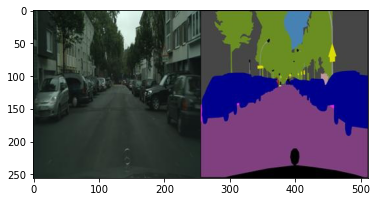

In [30]:
plt.imshow(tf.keras.preprocessing.image.load_img(random.choice(imgs_path)))
plt.show()

In [32]:
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def normalize(mask, image):
    mask = tf.cast(mask, tf.float32)/127.5 - 1
    image = tf.cast(image, tf.float32)/127.5 - 1
    return mask, image

def load_image(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w//2
    input_mask = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_mask = tf.image.resize(input_mask, (256, 256))
    input_image = tf.image.resize(input_image, (256, 256))
    
    if tf.random.uniform(())>0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_mask, input_image = normalize(input_mask, input_image)
    
    return input_mask, input_image

In [33]:
dataset = tf.data.Dataset.from_tensor_slices(imgs_path)

dataset = dataset.map(load_image)
BCTCH_SIZE = 32
BUFFER_SIZE = 200
dataset = dataset.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

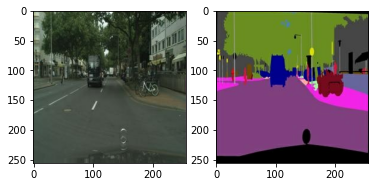

In [34]:
for mask, img in dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

In [35]:
imgs_test = glob.glob(r'../input/cityscapes-image-pairs/cityscapes_data/val/*.jpg')
dataset_test = tf.data.Dataset.from_tensor_slices(imgs_test)

In [36]:
def load_image_test(image_path):
    image = read_jpg(image_path)
    w = tf.shape(image)[1]
    w = w//2
    input_mask = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_mask = tf.image.resize(input_mask, (256, 256))
    input_image = tf.image.resize(input_image, (256, 256))
    
    input_mask, input_image = normalize(input_mask, input_image)
    
    return input_mask, input_image

In [37]:
dataset_test = dataset_test.map(load_image_test)
dataset_test = dataset_test.batch(BCTCH_SIZE)
dataset_test

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

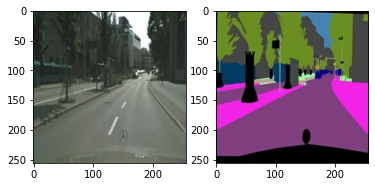

In [38]:
for mask, img in dataset_test.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 2, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))

In [39]:
def down(filters, size, apply_bn=True):
    model = tf.keras.Sequential()
    model.add( tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))
    if apply_bn:
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    return model

def up(filters, size, apply_drop=False):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, 
                                        padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    if apply_drop:
        model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.ReLU())
    return model

In [40]:
def Generator():
    inputs = tf.keras.layers.Input(shape=(256, 256, 3))
    
    down_stack = [
        down(64, 4, apply_bn=False),     
        down(128, 4), down(256, 4), down(512, 4),                  
        down(512, 4), down(512, 4), down(512, 4),                  
        down(512, 4)]
    
    up_stack = [
        up(512, 4, apply_drop=True), up(512, 4, apply_drop=True),     
        up(512, 4, apply_drop=True), up(512, 4),                        
        up(256, 4), up(128, 4), up(64, 4)]
    
    x = inputs
    skips = []     
    for d in down_stack:
        x = d(x)
        skips.append(x)
        
    skips = reversed(skips[ :-1])
    
    for u, skip in zip(up_stack, skips):
        x = u(x)
        x = tf.keras.layers.Concatenate()([x, skip])    # x为 128*128*128
        
    x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, 
                                        padding='same', 
                                        activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

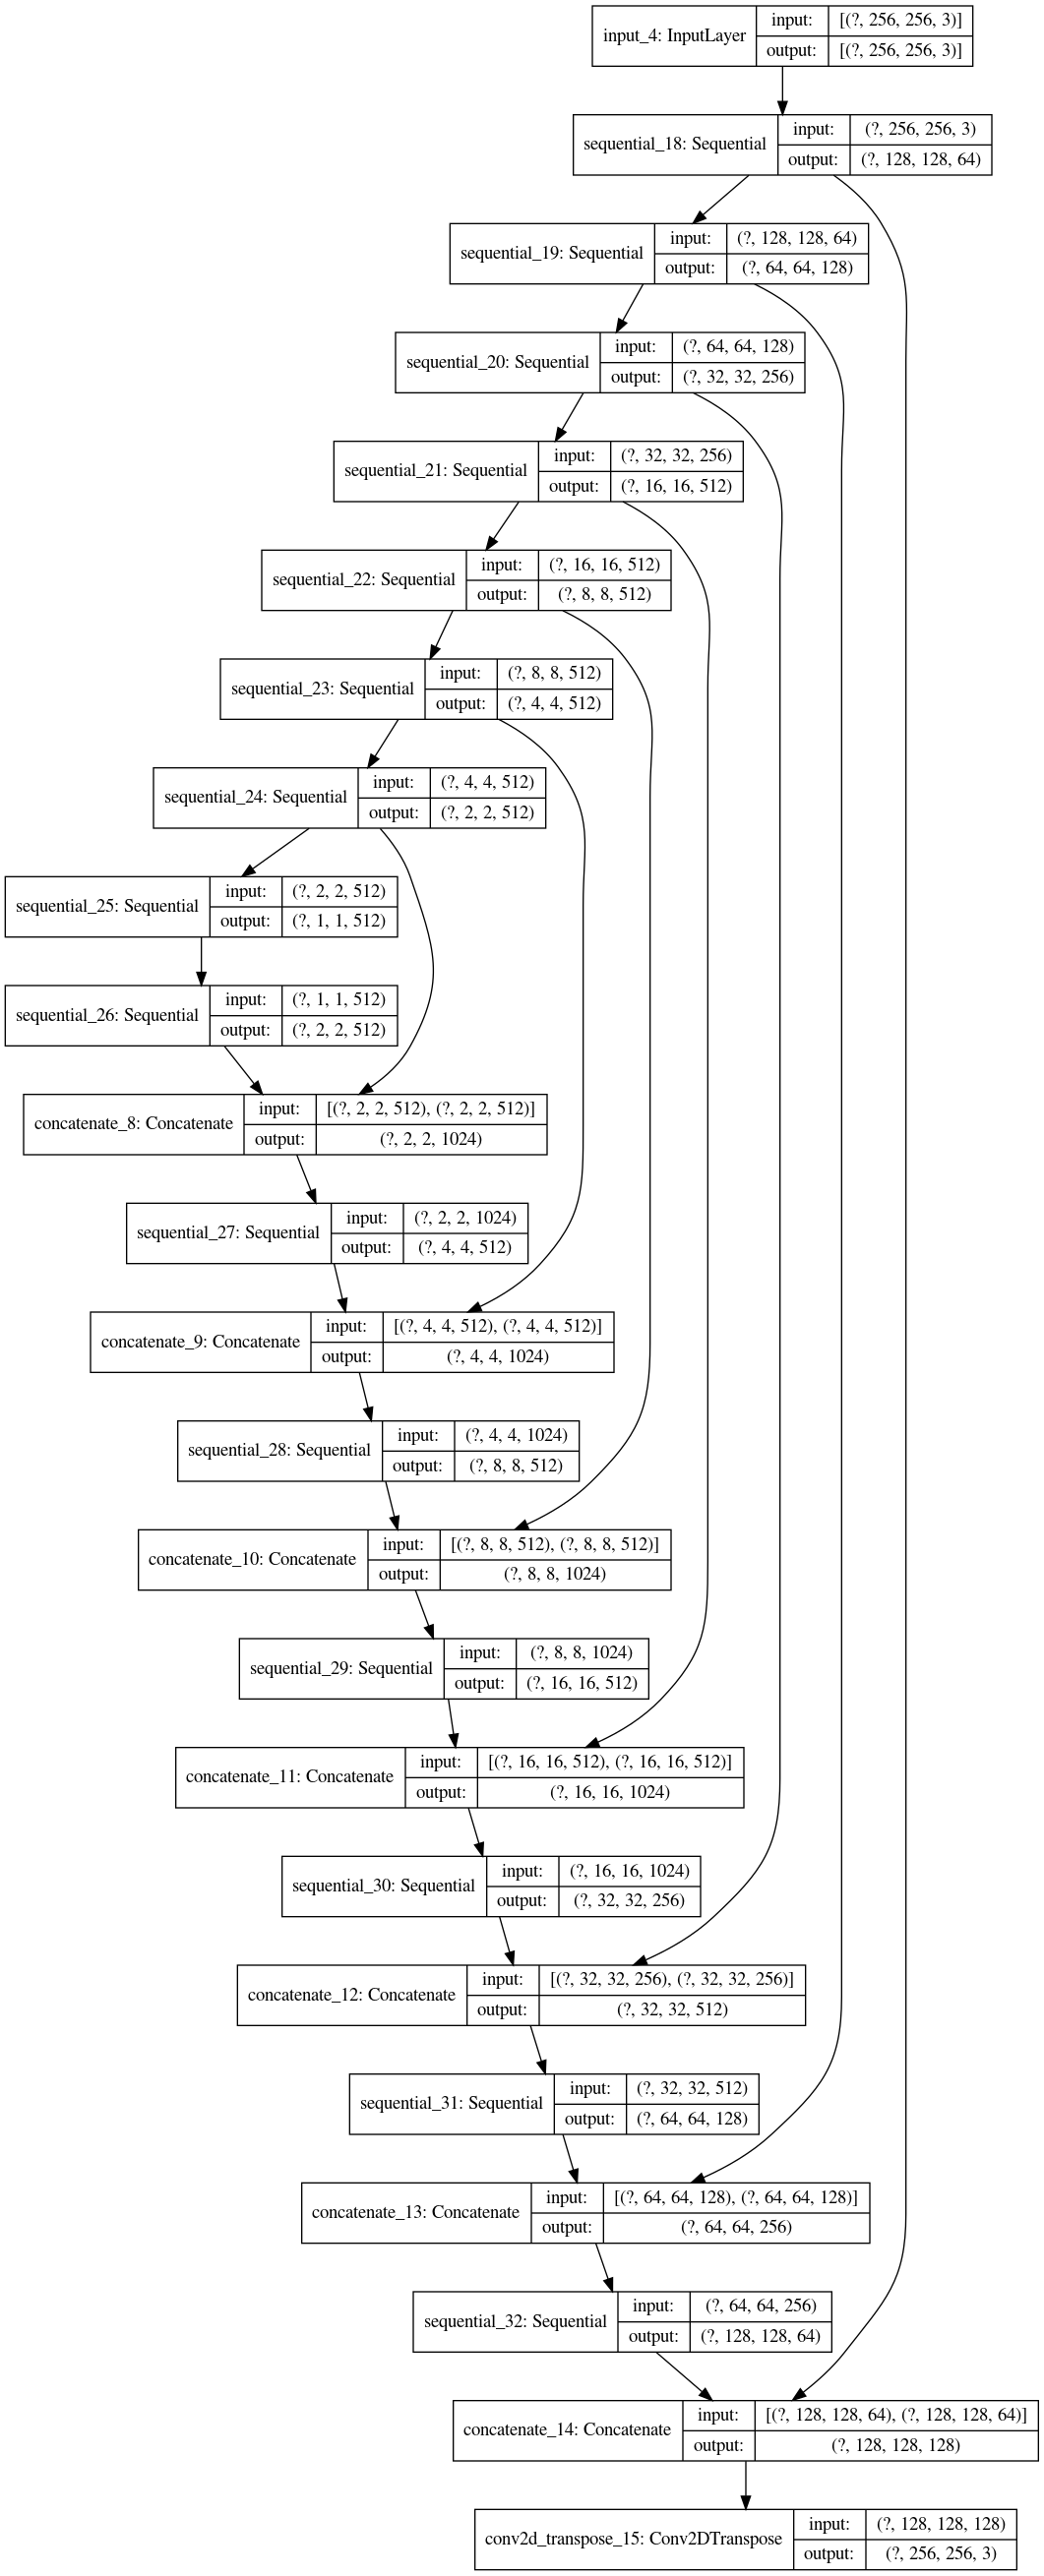

In [41]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True)

In [42]:
def Disc():
    inp = tf.keras.layers.Input(shape=(256, 256, 3))
    tar = tf.keras.layers.Input(shape=(256, 256, 3))
    
    x = tf.keras.layers.concatenate([inp, tar])   
    
    x = down(64, 4, apply_bn=False)(x)              
    x = down(128, 4)(x)                              
    x = down(256, 4)(x)                            
    
    x = tf.keras.layers.Conv2D(512, 4, strides=1, 
                               padding='same',
                               use_bias=False)(x)   
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv2D(1, 3, strides=1)(x)  
    
    return tf.keras.Model(inputs=[inp, tar], outputs=x)

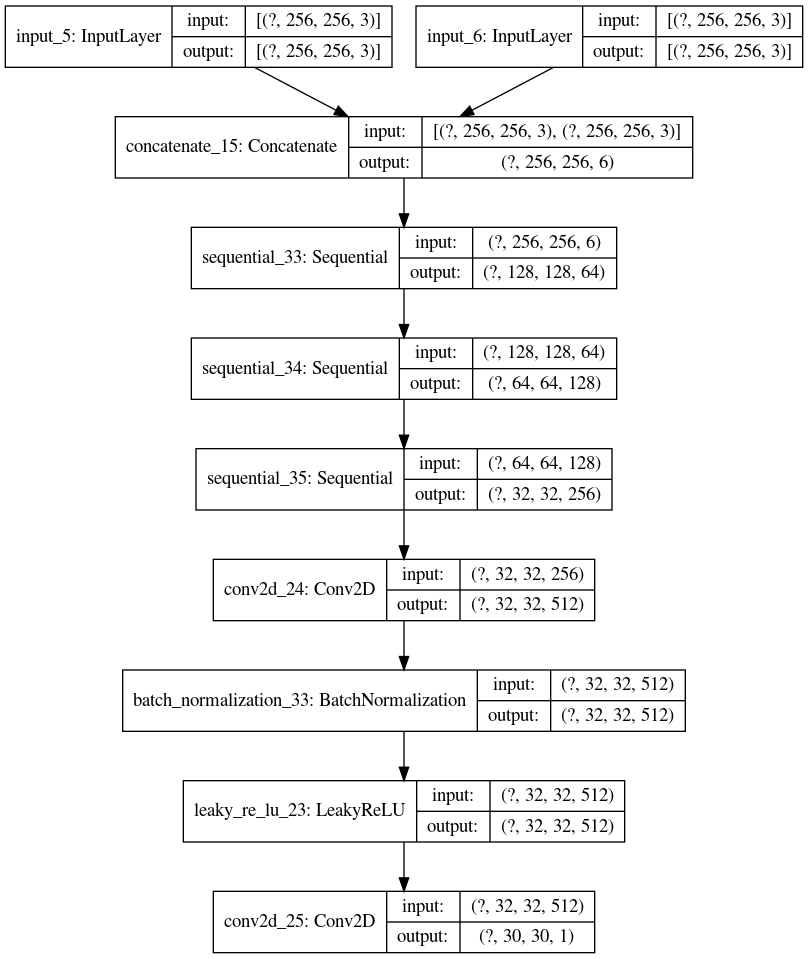

In [43]:
discriminator = Disc()
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [44]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [45]:
LAMBDA = 10
def gen_loss(d_gen_output, gen_output, target):
    gen_loss = loss_fn(tf.ones_like(d_gen_output), d_gen_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    return gen_loss + LAMBDA*l1_loss

In [46]:
def disc_loss(d_real_output, d_gen_output):
    real_loss = loss_fn(tf.ones_like(d_real_output), d_real_output)
    g_loss = loss_fn(tf.zeros_like(d_gen_output), d_gen_output)
    return real_loss + g_loss

In [47]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [48]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [49]:
EPOCHS = 100

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss = gen_loss(disc_generated_output, gen_output, target)
        disc_total_loss = disc_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_total_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [50]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs+1):
        for mask, image in train_ds:
            train_step(mask, image)
        if epoch%10 == 0:
            print('Epoch :', epoch)
            for example_input, example_target in test_ds.take(1):
                generate_images(generator, example_input, example_target)
        print()

Epoch : 0


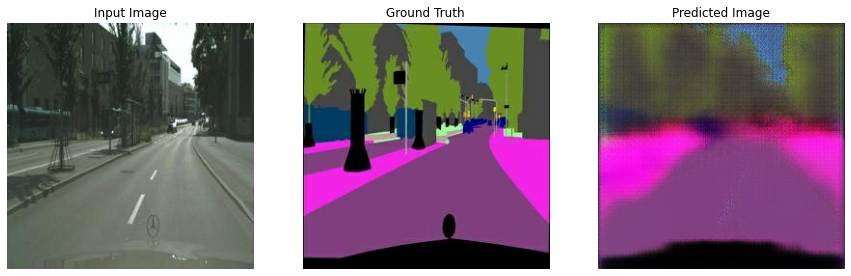











Epoch : 10


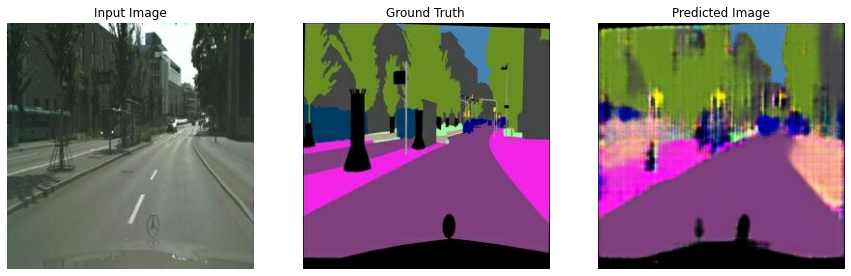











Epoch : 20


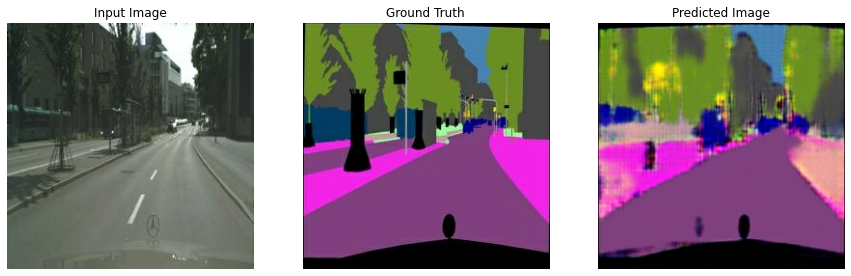










Epoch : 30


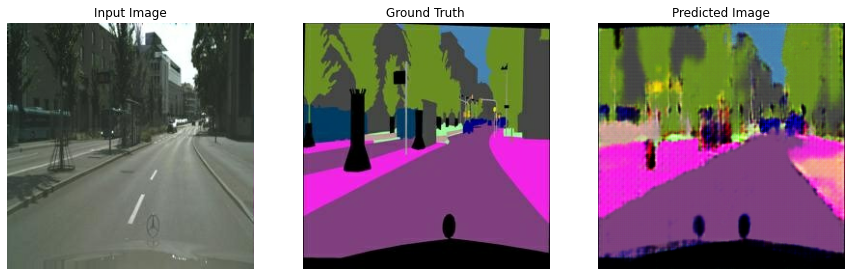











Epoch : 40


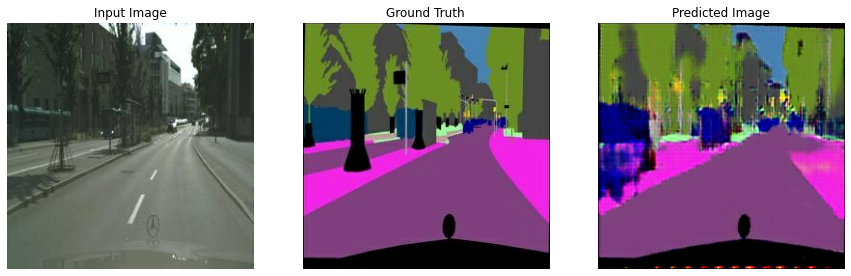











Epoch : 50


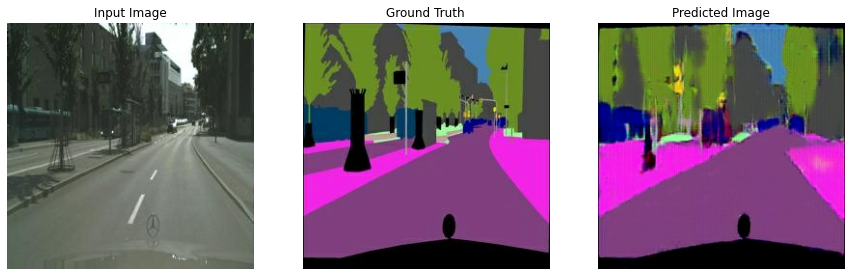











Epoch : 60


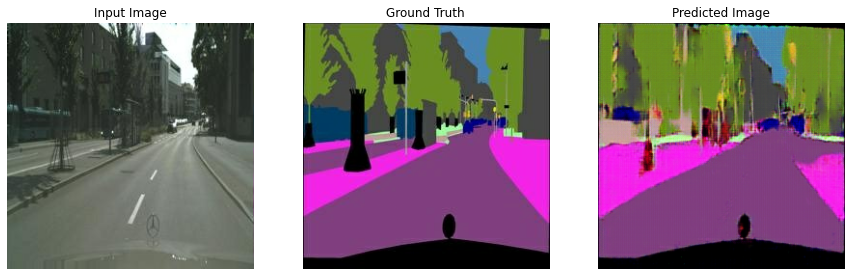











Epoch : 70


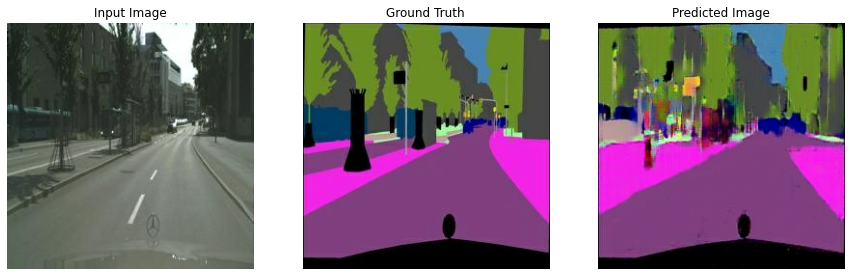











Epoch : 80


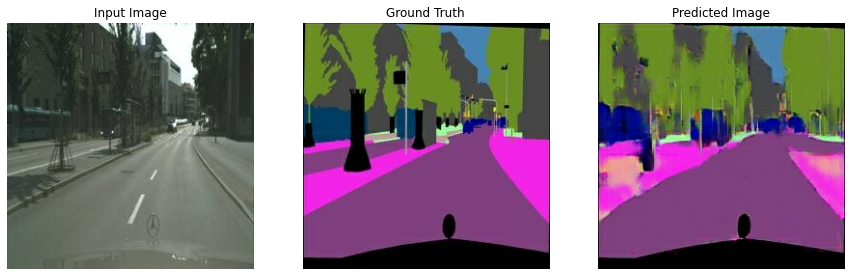











Epoch : 90


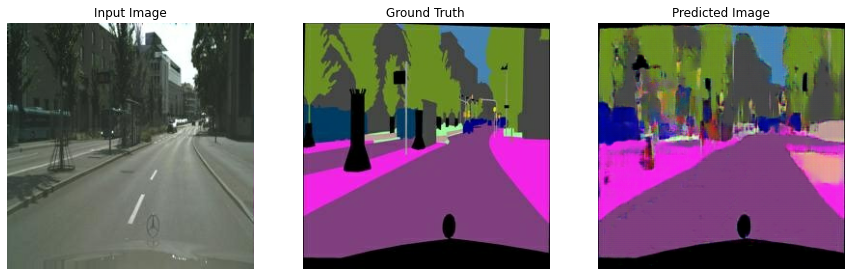










Epoch : 100


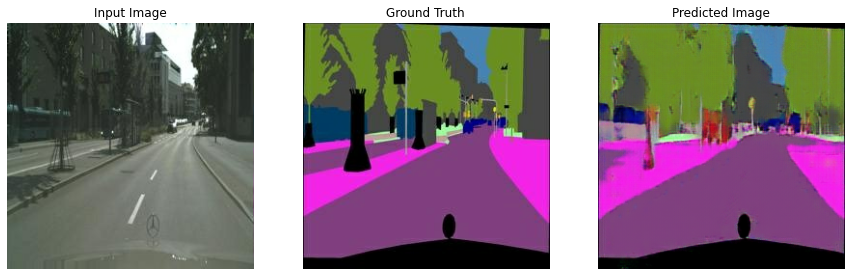

In [51]:
fit(dataset, EPOCHS, dataset_test)
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [72]:
masks = []
pred_masks = []
for img, mask in dataset_test.take(1):
    masks.append((mask))
    p = generator.predict(mask)
    pred_masks.append(p)

In [ ]:
a = tf.keras.preprocessing.image.array_to_img(masks[0])
a

In [ ]:
import keras.backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

iou = iou_coef(masks, pred_masks)
dice = dice_coef(masks, pred_masks)
print('IoU Score :', iou.numpy())
print('Dice Score :', dice.numpy())